In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from rpmml_project.pointmaze.point_maze import (MinariTrajectoryDataset, MinariTrajectoryDatasetWithActions, recover_actions_from_states, expand_spline_from_skip_list)

In [4]:
dataset = MinariTrajectoryDataset(
    dataset_name="D4RL/pointmaze/umaze-v2",
    horizon=32
)

In [5]:
env = dataset.dataset.recover_environment()

def unwrap_env(env):
    while hasattr(env, "env"):
        env = env.env
    return env

env = unwrap_env(env)     # <-- now env.model and env.sim work

mj_model = env.model          # or env.sim.model
mj_data = env.data

In [6]:
from matplotlib.patches import Rectangle
import mujoco

-2.0 2.0
-1.0 2.0
0.0 2.0
1.0 2.0
2.0 2.0
-2.0 1.0
2.0 1.0
-2.0 0.0
-1.0 0.0
0.0 0.0
2.0 0.0
-2.0 -1.0
2.0 -1.0
-2.0 -2.0
-1.0 -2.0
0.0 -2.0
1.0 -2.0
2.0 -2.0


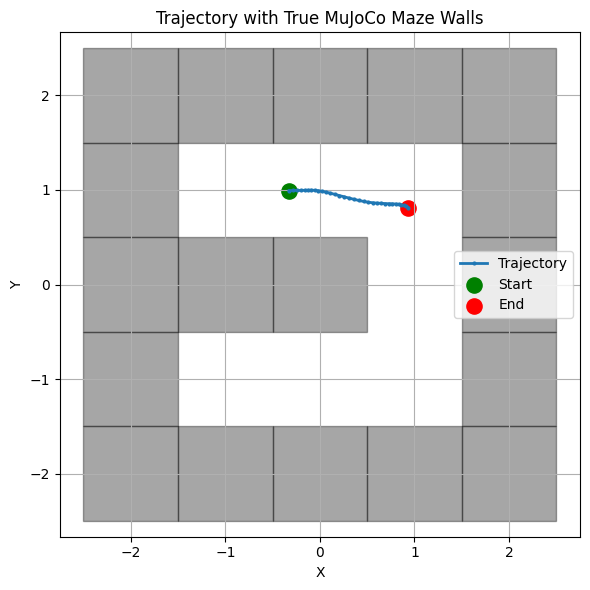

In [7]:
# -----------------------------
# Sample a trajectory window
# -----------------------------
idx = random.randint(0, len(dataset) - 1)
traj_norm = dataset[idx]
traj = dataset.denormalize(traj_norm).numpy()
xy = traj[:, :2]           # XY coordinates

# -----------------------------
# Plot the trajectory
# -----------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(xy[:, 0], xy[:, 1], marker='o', linewidth=2, markersize=2, label='Trajectory')
ax.scatter(xy[0, 0], xy[0, 1], c='green', s=120, label='Start')
ax.scatter(xy[-1, 0], xy[-1, 1], c='red', s=120, label='End')

# -----------------------------
# Render actual MuJoCo walls
# -----------------------------
for geom_id in range(mj_model.ngeom):

    # Get geom name
    name = mujoco.mj_id2name(mj_model, mujoco.mjtObj.mjOBJ_GEOM, geom_id)

    if name is None or not "block" in name:
        continue

    pos = mj_model.geom_pos[geom_id]     # center (x, y, z)
    size = mj_model.geom_size[geom_id]   # half-extents (hx, hy, hz)

    cx, cy = pos[:2]
    hx, hy = size[:2]
    print(cx, cy)

    rect = Rectangle(
        (cx - hx, cy - hy),
        2 * hx,
        2 * hy,
        color="black",
        alpha=0.35,
        zorder=0
    )
    ax.add_patch(rect)


# -----------------------------
# Final figure styling
# -----------------------------
ax.set_title("Trajectory with True MuJoCo Maze Walls")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)
ax.legend()
plt.tight_layout()

plt.show()

In [28]:
datasetWithAcceleration = MinariTrajectoryDatasetWithActions(
    dataset_name="D4RL/pointmaze/umaze-v2",
    horizon=32
)

In [8]:
batch = datasetWithAcceleration[np.random.randint(len(datasetWithAcceleration))]
obs_norm = batch["obs"].numpy()          # (H,4) normalized
actions = batch["act"].numpy()           # (H,2) true accelerations

# Denormalize states
obs = datasetWithAcceleration.denormalize(obs_norm)      # (H,4)

pos = obs[:, :2]                         # true positions
vel_true = obs[:, 2:4]                   # true velocities (vx, vy)

# -----------------------------------------------------
# Recover velocity and acceleration with our FD method
# -----------------------------------------------------
vel_fd, acc_fd = recover_actions_from_states(obs, dt=0.05)
print(vel_fd.shape)
print(acc_fd.shape)
# Align true velocity with FD velocity (T-1)
vel_true_aligned = vel_true[:-1]         # drop final velocity
print(vel_true_aligned.shape)
# Align accelerations
acc_true_aligned = actions[1:-1]         # (T-2)
print(acc_true_aligned.shape)
# -----------------------------------------------------
# Compute metrics
# -----------------------------------------------------
vel_mse = np.mean((vel_fd - vel_true_aligned)**2)
vel_mae = np.mean(np.abs(vel_fd - vel_true_aligned))

acc_mse = np.mean((acc_fd - acc_true_aligned)**2)
acc_mae = np.mean(np.abs(acc_fd - acc_true_aligned))

print("\n==================== METRICS ====================")
print("Velocity MSE:", vel_mse)
print("Velocity MAE:", vel_mae)
print("Acceleration MSE:", acc_mse)
print("Acceleration MAE:", acc_mae)
print("=================================================\n")


(31, 2)
(30, 2)
(31, 2)
(30, 2)

==================== METRICS ====================
Velocity MSE: 2.8316557765840247
Velocity MAE: 1.1375839264182352
Acceleration MSE: 0.002064544840185856
Acceleration MAE: 0.0373464037369349



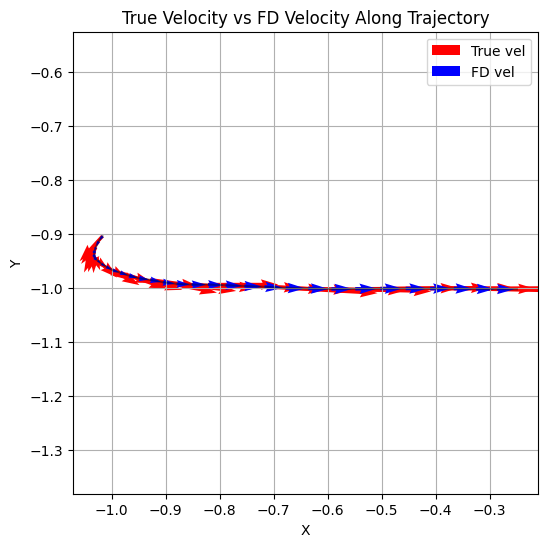

In [11]:
plt.figure(figsize=(6,6))
plt.plot(pos[:,0], pos[:,1], 'k-', alpha=0.4)

plt.quiver(
    pos[:-1,0], pos[:-1,1],
    vel_true_aligned[:,0], vel_true_aligned[:,1],
    color='r', scale=20, label="True vel"
)
plt.quiver(
    pos[:-1,0], pos[:-1,1],
    vel_fd[:,0], vel_fd[:,1],
    color='b', scale=20, label="FD vel"
)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("True Velocity vs FD Velocity Along Trajectory")
plt.axis("equal")
plt.grid()
plt.legend()
plt.show()


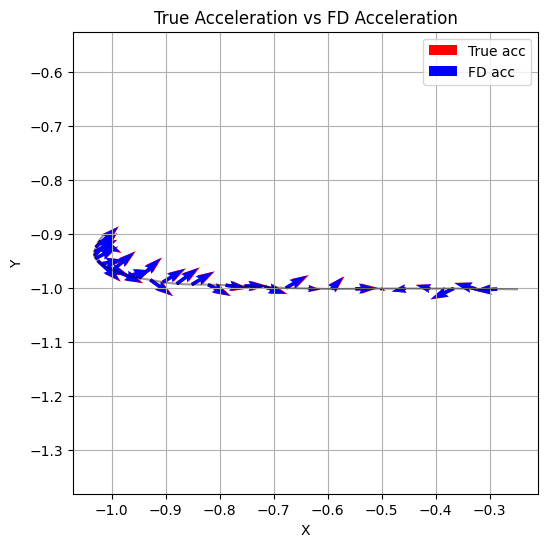

In [12]:
plt.figure(figsize=(6,6))
plt.plot(pos[:,0], pos[:,1], 'k-', alpha=0.4)

plt.quiver(
    pos[1:-1,0], pos[1:-1,1],
    acc_true_aligned[:,0], acc_true_aligned[:,1],
    color='red', scale=20, label="True acc"
)
plt.quiver(
    pos[1:-1,0], pos[1:-1,1],
    acc_fd[:,0], acc_fd[:,1],
    color='blue', scale=20, label="FD acc"
)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("True Acceleration vs FD Acceleration")
plt.axis("equal")
plt.grid()
plt.legend()
plt.show()


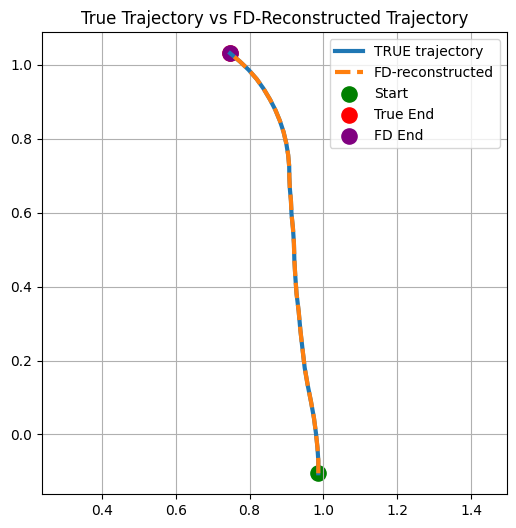

In [29]:
# this is pretty close
# ------------------------------------------------------------
# Sample one trajectory window (states + true accelerations)
# ------------------------------------------------------------
batch = datasetWithAcceleration[np.random.randint(len(datasetWithAcceleration))]

obs_norm = batch["obs"].numpy()      # (H,4) normalized
act_true = batch["act"].numpy()      # (H,2) true accelerations

# Denormalize positions & velocities
obs = datasetWithAcceleration.denormalize(obs_norm)
pos = obs[:, :2]                     # (H,2)
vel_true = obs[:, 2:4]               # (H,2)

# Estimate velocities & accelerations via FD
vel_fd, acc_fd = recover_actions_from_states(obs, dt=0.05)

# ------------------------------------------------------------
# Simulate forward using FD dynamics
# ------------------------------------------------------------
dt = 0.05
H = len(obs)

x_fd = np.zeros((H,2))
v_fd = np.zeros((H,2))

# Initial conditions match ground truth
x_fd[0] = pos[0]
v_fd[0] = vel_fd[0]

for t in range(H-2):
    # Update velocity
    v_fd[t+1] = v_fd[t] + acc_fd[t] * dt
    # Update position
    x_fd[t+1] = x_fd[t] + v_fd[t] * dt

# Fill final position for nicer plot
x_fd[-1] = x_fd[-2] + v_fd[-2] * dt

# ------------------------------------------------------------
# Plot comparison
# ------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.plot(pos[:,0], pos[:,1], label="TRUE trajectory", linewidth=3)
plt.plot(x_fd[:,0], x_fd[:,1], label="FD-reconstructed", linestyle="--", linewidth=3)

plt.scatter(pos[0,0], pos[0,1], c="green", s=120, label="Start")
plt.scatter(pos[-1,0], pos[-1,1], c="red", s=120, label="True End")
plt.scatter(x_fd[-1,0], x_fd[-1,1], c="purple", s=120, label="FD End")

plt.legend()
plt.title("True Trajectory vs FD-Reconstructed Trajectory")
plt.grid(True)
plt.axis("equal")
plt.show()


In [8]:
# From here on out, let's generate a sample list of tuples with state and timesteps skipped
# And use it for spine interpolation

def generate_skipped_waypoints(positions, max_skip=5):
    """
    Given a trajectory of 2D positions (T,2),
    produce a list of (state_xy, skip_amount).

    Args:
        positions: numpy array of shape (T,2)
        max_skip: maximum number of timesteps to skip forward

    Returns:
        waypoints: list of tuples (state_xy, skip_k)
    """
    T = len(positions)
    waypoints = []

    t = 0
    while t < T - 1:
        remaining = T - 1 - t
        skip = random.randint(1, min(max_skip, remaining))

        s = positions[t]
        waypoints.append( (s.copy(), skip) )

        t += skip

    return waypoints

In [9]:
pos = traj[:, :2]   
skip_list = generate_skipped_waypoints(pos) 
p_spline, v_spline, a_spline = expand_spline_from_skip_list(skip_list)



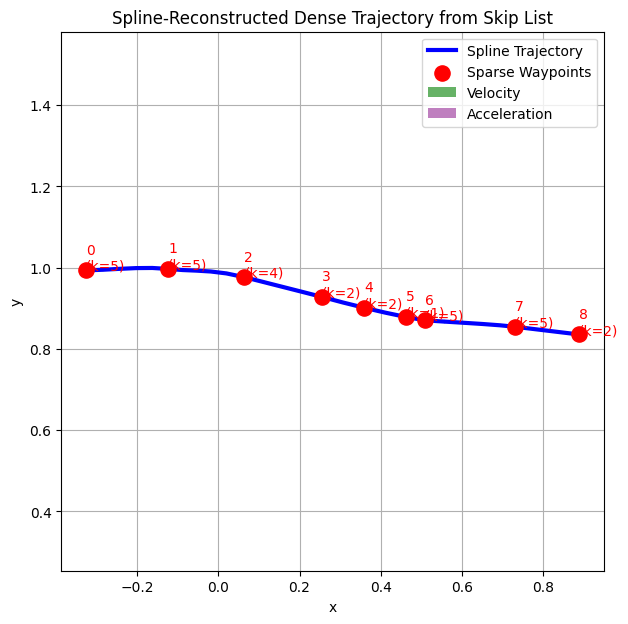

In [15]:


# ---------------------------------------
# Extract the sparse positions from skip_list
# ---------------------------------------
sparse_pos = np.array([p for p, k in skip_list])

# ---------------------------------------
# Start plotting
# ---------------------------------------
plt.figure(figsize=(7,7))

# ---- Plot spline trajectory (dense) ----
plt.plot(
    p_spline[:,0], p_spline[:,1],
    linewidth=3, color="blue", label="Spline Trajectory"
)

# ---- Plot sparse waypoints ----
plt.scatter(
    sparse_pos[:,0], sparse_pos[:,1],
    color="red", s=120, zorder=5,
    label="Sparse Waypoints"
)

# Label sparse waypoints
for i, (p, k) in enumerate(skip_list):
    plt.text(
        p[0], p[1],
        f"{i}\n(k={k})",
        fontsize=10, color="red"
    )

# ---------------------------------------
# Velocity vectors
# ---------------------------------------
plt.quiver(
    p_spline[:,0], p_spline[:,1],
    v_spline[:,0], v_spline[:,1],
    color="green", scale=20, width=0.004,
    alpha=0.6, label="Velocity"
)

# ---------------------------------------
# Acceleration vectors
# ---------------------------------------
plt.quiver(
    p_spline[:,0], p_spline[:,1],
    a_spline[:,0], a_spline[:,1],
    color="purple", scale=50, width=0.003,
    alpha=0.5, label="Acceleration"
)

# ---------------------------------------
# Styling
# ---------------------------------------
plt.title("Spline-Reconstructed Dense Trajectory from Skip List")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis("equal")
plt.legend()

plt.show()


In [19]:
print("===================================================")
print(" WAYPOINT COMPARISON: FD Predicted vs Sparse")
print("===================================================\n")

errors = []

current_idx = 0

for i, (sparse_pos, skip) in enumerate(skip_list[:-1]):   # second-last
    next_sparse_pos = skip_list[i+1][0]
    k = skip

    pred_pos = p_spline[current_idx].copy()
    pred_vel = vel_fd[current_idx].copy()

    for step in range(k):

        # prevent IndexError by clamping index
        acc_idx = min(current_idx + step, len(acc_fd) - 1)

        pred_vel = pred_vel + acc_fd[acc_idx] * 0.05
        pred_pos = pred_pos + pred_vel * 0.05

    true_pos = next_sparse_pos
    err = np.linalg.norm(pred_pos - true_pos)
    errors.append(err)

    print(f"Segment {i}: skip = {k}")
    print("  True waypoint:      ", true_pos)
    print("  Predicted waypoint: ", pred_pos)
    print("  Error (L2):          {:.6f}\n".format(err))

    current_idx += k

print("===================================================")
print("Mean Error:  ", np.mean(errors))
print("Max Error:   ", np.max(errors))
print("===================================================")


 WAYPOINT COMPARISON: FD Predicted vs Sparse

Segment 0: skip = 5
  True waypoint:       [-0.12382783  0.99700298]
  Predicted waypoint:  [-0.12875059  0.99275875]
  Error (L2):          0.006500

Segment 1: skip = 5
  True waypoint:       [0.06410962 0.97668109]
  Predicted waypoint:  [0.07536959 0.96746627]
  Error (L2):          0.014550

Segment 2: skip = 4
  True waypoint:       [0.25555426 0.92798624]
  Predicted waypoint:  [0.25961009 0.92633292]
  Error (L2):          0.004380

Segment 3: skip = 2
  True waypoint:       [0.35828982 0.90159068]
  Predicted waypoint:  [0.35990667 0.90297372]
  Error (L2):          0.002128

Segment 4: skip = 2
  True waypoint:       [0.46189168 0.87869301]
  Predicted waypoint:  [0.45651461 0.8827087 ]
  Error (L2):          0.006711

Segment 5: skip = 1
  True waypoint:       [0.50939096 0.87045673]
  Predicted waypoint:  [0.50794711 0.87562775]
  Error (L2):          0.005369

Segment 6: skip = 5
  True waypoint:       [0.72976893 0.85462148]
 

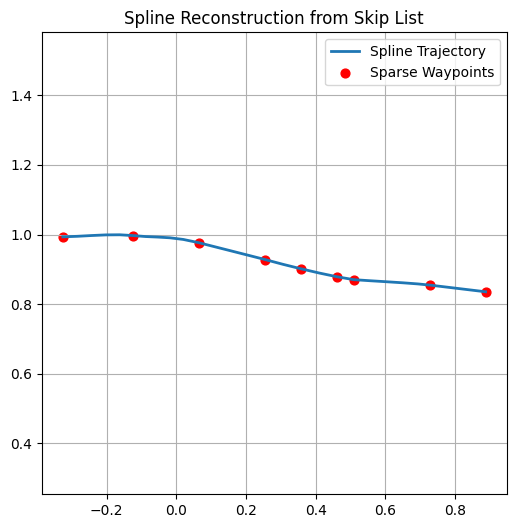

In [20]:
sparse_positions = np.array([p for (p, k) in skip_list])
plt.figure(figsize=(6,6))
plt.plot(p_spline[:,0], p_spline[:,1], label="Spline Trajectory", linewidth=2)
plt.scatter(sparse_positions[:,0], sparse_positions[:,1], color='red', s=40, label="Sparse Waypoints")
plt.axis('equal')
plt.legend()
plt.title("Spline Reconstruction from Skip List")
plt.grid()
plt.show()

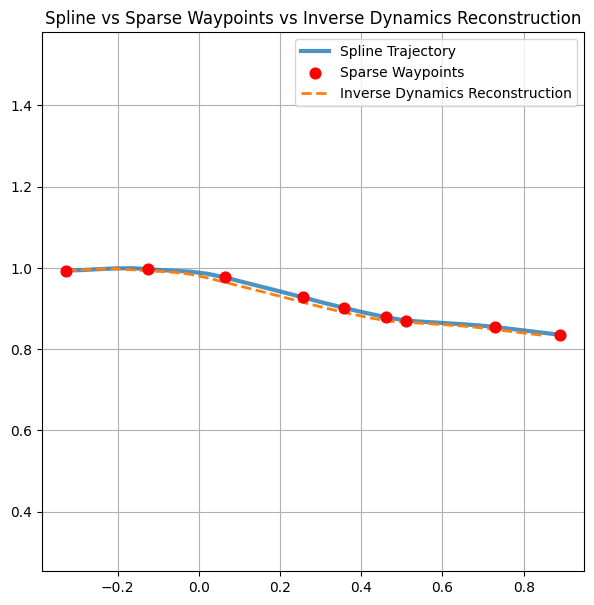

In [21]:
# Recovered velocities and accelerations using inverse-dynamics model:
vel_fd, acc_fd = recover_actions_from_states(p_spline, dt=0.05)

# -----------------------------------------------------------
# 2. Reconstruct trajectory using FD velocity + acceleration
# -----------------------------------------------------------
dt = 0.05

p_recon = [p_spline[0].copy()]
v_recon = [vel_fd[0].copy()]

for t in range(len(acc_fd)):
    # update velocity using recovered acceleration
    v_next = v_recon[-1] + acc_fd[t] * dt

    # update position
    p_next = p_recon[-1] + v_next * dt

    v_recon.append(v_next)
    p_recon.append(p_next)

# Add final step (vel_fd has T-1 velocities)
p_recon = np.array(p_recon)    # shape (T-1,2)
# -----------------------------------------------------------
# 3. Visualization
# -----------------------------------------------------------
plt.figure(figsize=(7,7))

# Spline trajectory (ground truth dense)
plt.plot(
    p_spline[:,0], p_spline[:,1],
    label="Spline Trajectory", linewidth=3, alpha=0.8
)

# Sparse waypoints
sparse_positions = np.array([p for (p,k) in skip_list])
plt.scatter(
    sparse_positions[:,0], sparse_positions[:,1],
    color='red', s=60, label="Sparse Waypoints", zorder=5
)

# Reconstruction from FD inverse dynamics
plt.plot(
    p_recon[:,0], p_recon[:,1],
    '--', linewidth=2, label="Inverse Dynamics Reconstruction"
)

plt.axis('equal')
plt.title("Spline vs Sparse Waypoints vs Inverse Dynamics Reconstruction")
plt.legend()
plt.grid()
plt.show()
